<a href="https://colab.research.google.com/github/hpink97/loan_default_predictor/blob/main/03_ml_preprocessing_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data preprocessing and Model training** 💻




### Load modules

In [2]:
#!pip install bayesian-optimization
#!pip install miceforest --no-cache-dir

In [3]:

import pandas as pd
import numpy as np 
import gc #free up memory
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf ##forest based imputation


import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score,precision_recall_curve,roc_curve, auc

from sklearn.preprocessing import RobustScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_classif 


## `Dataset` class for ML preprocessing

The `Dataset` class is designed to handle the preprocessing and splitting of a dataset for machine learning tasks. Here is a summary of its functionality:

1. Initialization: The class takes in a pandas DataFrame (`df`) representing the dataset and the target variable (`target`). It also accepts additional parameters like `is_test` to indicate if the dataset is a test set, `scaler` for scaling numeric columns, and `trained_cols` for indicating specific columns to be used in the final dataset.

2. Preprocessing: The `preprocess()` method performs preprocessing tasks on the dataset. It includes basic imputations for missing values, smart imputations using the `miceforest` package for remaining missing values, scaling of numeric columns, and label encoding for binary columns. It also performs one-hot encoding for categorical columns.

3. Splitting Data: The `split_data()` method splits the preprocessed dataset into training, evaluation, and testing sets. It takes parameters like `test_size` and `eval_size` to control the size of the test and evaluation sets, respectively. It prints information about the sizes and positive rates of each split.


In [6]:
class Dataset:
    def __init__(self, df, target,is_test=False, scaler=None, trained_cols = None):
      input_df = df.copy()
      self.is_test = is_test
      self.target = target
      self.X_train = None
      self.X_test = None
      self.X_eval = None
      self.y_eval = None
      self.y_train = None
      self.y_test = None
      self.preprocessed = False
      self.scaler = scaler
      self.label_encoders = None
      if self.is_test:
        self.y = None
        self.X = input_df
      else:
        self.y = input_df[self.target]
        self.X = input_df.drop(columns=[self.target])

    ##method to pre-process the df
    def preprocess(self, impute_dict=None, final_X_cols= None,
                   imputation_kernel_iterations = 4, imputation_kernel_ntrees = 50):
       # Basic imputations
      if impute_dict is not None:
        print(f'Performing basic imputations based on {len(impute_dict)} features supplied impute_dict')
        for col, strategy in impute_dict.items():
          if col not in self.X.columns:
            print(f"Skipping imputation for column '{col}' as it does not exist in the dataset.")
            continue
          if strategy == 'mean':
              self.X[col].fillna(self.X[col].mean(), inplace=True)
          elif strategy == 'median':
              self.X[col].fillna(self.X[col].median(), inplace=True)
          elif isinstance(strategy, str) and strategy.startswith('percentile_'):
              percentile = float(strategy.split('_')[1])
              self.X[col].fillna(self.X[col].quantile(percentile / 100), inplace=True)
          elif isinstance(strategy, (int, float)):
              self.X[col].fillna(strategy, inplace=True)
          else:
              raise ValueError(f"Invalid imputation strategy for column '{col}'.")
    #find numeric columns
      numeric_cols = self.X.select_dtypes(include=['int64', 'float64']).columns
      print(numeric_cols)

      ## smart impuations - decision tree based method
      count_NA = self.X.isna().sum()
      remaining_NA_cols = count_NA[count_NA>0].shape[0]
      print(remaining_NA_cols)
      if  remaining_NA_cols> 0:
        print(f'Performing decision-tree based imputations of {remaining_NA_cols} remaining features with missing data')
        kernal = mf.ImputationKernel(
            self.X[numeric_cols],
            random_state=42
            )
        # Run the MICE algorithm for 2 iterations
        kernal.mice(iterations=imputation_kernel_iterations,
                    n_estimators=imputation_kernel_ntrees)
        X_numeric_imputed = kernal.complete_data()
        self.X[numeric_cols] = X_numeric_imputed
      
      ##scale numeric cols
      print('Scaling numeric data')
      if self.scaler is None:
        self.scaler = StandardScaler()
        self.X[numeric_cols] = self.scaler.fit_transform(self.X[numeric_cols])
      else:
        scaler_trained_features = self.scaler.feature_names_in_
        missing_cols = set(scaler_trained_features) - set(self.X.columns)
        if len(missing_cols) >0:
          print(f"{len(missing_cols)} variables that scaler was originally trained on are missing - will replace with zeros")
          for col in missing_cols:
            self.X[col] = 0
        self.X[scaler_trained_features] = self.scaler.transform(self.X[scaler_trained_features])
  
      
      # Perform label encoding for binary columns
      print('One-hot-encoding categorical vars')
      binary_cols = [col for col in self.X.columns if self.X[col].nunique() == 2]
      self.label_encoders = {}

      # Label encode binary columns
      for col in binary_cols:
          label_encoder = LabelEncoder()
          self.X[col] = label_encoder.fit_transform(self.X[col])
          # Store the label encoder for later use
          self.label_encoders[col] = label_encoder
      
      # Perform one-hot encoding for categorical columns
      categorical_cols = [col for col in self.X.columns if self.X[col].dtype == 'object' and col not in binary_cols]
      self.X = pd.get_dummies(self.X, columns=categorical_cols)

      if final_X_cols is not None:
        print('splicing dataset to include only final_X_cols columns')
        missing_cols = set(final_X_cols) - set(self.X.columns)
        for col in missing_cols:
          self.X[col] = 0
        self.X = self.X[final_X_cols]

      self.preprocessed = True
    

    def split_data(self, test_size=0.15,eval_size = 0.15, random_state=42):
        if not self.preprocessed:
          raise RuntimeError("Data has not been preprocessed. Please run the preprocess method.")
        
        if self.is_test:
          raise RuntimeError("Cannot run split_data() method on a test set")

        
        X_train_eval, self.X_test, y_train_eval, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )

        eval_split_size = eval_size/(1-test_size)
        self.X_train, self.X_eval, self.y_train, self.y_eval = train_test_split(
            X_train_eval, y_train_eval, test_size=eval_split_size, random_state=random_state)

        print(f"{self.X_train.shape[0]} training samples, {self.X_eval.shape[0]} evaluation samples and {self.X_test.shape[0]} testing samples")
        print(f"{self.y_train.sum()} ({self.y_train.mean()*100:.3f}%) positives in training set")
        print(f"{self.y_eval.sum()} ({self.y_eval.mean()*100:.3f}%) positives in evaluation set")
        print(f"{self.y_test.sum()} ({self.y_test.mean()*100:.3f})% positives in testing set")


## `Model` Class for training xgboost models

The model class provides a streamlined workflow for feature selection, model training, and evaluation of xgboost models.

Here is a summary of the key features and methods of the Model class:



1.   **Initialisation**: The class is initialized with the necessary input data using the `Dataset` class, including the training and test sets (`X_train`, `X_test`) and their corresponding target variables (`y_train`, `y_test`).
2.   **Feature Selection**: The `select_features()` method allows you to perform feature selection using the `sklearn.feature_selection.SelectKBest` algorithm. It selects the top num_features based on mutual information classification scores.
3. **Model Training**: The `train_model()` method trains an XGBoost classifier using the specified xgboost_params. It uses the training data and evaluates the model's performance on the evaluation set (`X_eval`, `y_eval`). Early stopping is implemented to prevent overfitting.
4. **Model Evaluation**: The `evaluate_model()` method calculates and prints various evaluation metrics, including F1 score, accuracy, precision, recall, specificity, ROC AUC score, and balanced accuracy. It also selects the optimal threshold for determining binary predictions based on the F1 score.
5. **Performance Visualisation**: The class provides several plotting methods to visualise model performance, including `plot_roc_auc()` to visualize the ROC curve and calculate the AUC score, `plot_predictions()` to plot the predicted probabilities against the true labels, and `plot_feature_importance()` to display the feature importances using a bar plot.

In [7]:
class Model:
    ##initialise the model class - taking instance of `Dataset` class an input
    def __init__(self, dataset_class):
        if not isinstance(dataset_class.X_train, pd.DataFrame) or not isinstance(dataset_class.X_test, pd.DataFrame):
            raise TypeError("X_train and X_test must be pandas DataFrames")
        if not isinstance(dataset_class.y_train, pd.Series) or not isinstance(dataset_class.y_test, pd.Series):
            raise TypeError("y_train and y_test must be pandas Series")
        ## take train-eval-test split datasets from input
        self.X_train = dataset_class.X_train
        self.X_eval = dataset_class.X_eval
        self.X_test = dataset_class.X_test
        self.y_train = dataset_class.y_train
        self.y_eval = dataset_class.y_eval
        self.y_test = dataset_class.y_test
        ##set up attributes to be used later
        self.y_pred = None
        self.xgboost_params = None
        self.num_features = None
        self.feature_names = dataset_class.X_train.columns
        self.selected_features = None
        self.model = None
        self.is_model_trained = False


    ##define method to select best n features in dataset
    ##basically a wrapper for SelectKBest from sklearn
    def select_features(self, num_features):
      if not isinstance(num_features, int) :
        raise TypeError("num_features must be an int")

      #ensure num features is in correct range
      num_features = max(min(int(num_features), self.X_train.shape[1]), 2)
      ##perform feature selection
      selector = SelectKBest(score_func=f_classif, k=num_features)
      selector.fit(self.X_train, self.y_train)
      mask = selector.get_support()
      ##splice X datasets for the selected features
      self.selected_features = self.feature_names[mask]
      self.X_train = self.X_train[self.selected_features]
      self.X_eval = self.X_eval[self.selected_features]
      self.X_test = self.X_test[self.selected_features]
    

    ## defne method to train the classifier
    def train_model(self, 
                    xgboost_params,
                    print_training_evaluation=False ,
                    num_boost_round=700,
                    early_stopping_rounds=20):
      self.xgboost_params = xgboost_params
      ##create xgb Matrix objects for datasets
      dtrain = xgb.DMatrix(self.X_train, label=self.y_train)
      ##
      deval = xgb.DMatrix(self.X_eval, label = self.y_eval)
      self.model = xgb.train(self.xgboost_params,
                             dtrain = dtrain, 
                             evals=[(deval, 'eval')],
                             verbose_eval=print_training_evaluation,
                             num_boost_round=num_boost_round,
                             early_stopping_rounds=early_stopping_rounds )
      print('Model training completed')
      self.is_model_trained = True

    def roc_auc(self):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before it can be evaluated")
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)

      roc_auc = roc_auc_score(self.y_test, self.y_pred)

      return roc_auc
    
    def evaluate_model(self):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before it can be evaluated")
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)
      ##select best threshold for determining 
      best_threshold = 0
      best_f1 = 0
      
      # Iterate over different threshold values
      for threshold in np.arange(0.1, 1.0, 0.05):
          y_pred_binary = (self.y_pred >= threshold).astype(int)
          f1 = f1_score(self.y_test, y_pred_binary)

          if f1 > best_f1:
              best_f1 = f1
              best_threshold = threshold
      
      # Convert predicted probabilities to binary predictions based on the best threshold
      y_pred_binary = (self.y_pred >= best_threshold).astype(int)
      
      # Calculate accuracy metrics
      accuracy = accuracy_score(self.y_test, y_pred_binary)
      precision = precision_score(self.y_test, y_pred_binary)
      recall = recall_score(self.y_test, y_pred_binary)
      specificity = recall_score(self.y_test, y_pred_binary, pos_label=0)
      roc_auc = self.roc_auc()
      balanced_accuracy = balanced_accuracy_score(self.y_test, y_pred_binary)
      
      # Print the metrics
      print(f"Optimal Threshold: {best_threshold:.3f}")
      print(f"F1 Score: {best_f1:.3f}")
      print(f"Accuracy: {accuracy:.3f}")
      print(f"Precision: {precision:.3f}")
      print(f"Recall (Sensitivity): {recall:.3f}")
      print(f"Specificity (True Negative Rate): {specificity:.3f}")
      print(f"ROC AUC Score: {roc_auc:.3f}")
      print(f"Balanced Accuracy: {balanced_accuracy:.3f}")

    
    def plot_roc_auc(self):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before it can be evaluated")
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)
      
      fpr, tpr, _ = roc_curve(self.y_test, self.y_pred)
      roc_auc = self.roc_auc()
      plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()
    def plot_predictions(self):
      if self.y_pred is None:
        dtest = xgb.DMatrix(self.X_test)
        self.y_pred = self.model.predict(dtest)
            
      sns.regplot(x=self.y_pred, y=self.y_test, scatter_kws={'alpha': 0.3})
      plt.xlabel('Predicted Probabilities')
      plt.ylabel('True Labels')
      plt.title('Predicted Probabilities vs. True Labels')
      plt.show()
    
    
    def plot_feature_importance(self, n_features =None):
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before feature importances can be evaluated")

      feature_importances = self.model.get_score(importance_type='weight')
      if n_features is None:
        n_features = len(feature_importances)

      sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

      # Extract feature names and importance scores
      features = [x[0] for x in sorted_feature_importances]
      importances = [x[1] for x in sorted_feature_importances]

      # Create a bar plot of sorted feature importances
      plt.figure(figsize=(8, 9.5))
      plt.barh(features[0:(n_features-1)][::-1], 
               importances[0:(n_features-1)][::-1])
      plt.xlabel('Importance')
      plt.ylabel('Features')
      plt.title(f'Top {n_features} Features')
      plt.tight_layout()
      plt.show()

    def predict_prob(self, new_dataset, threshold = None): 
      if not self.is_model_trained:
          raise RuntimeError("Model must be trained before new predictions can be made")
      if isinstance(new_dataset, pd.DataFrame):
        data = new_dataset[self.X_train.columns]
      elif isinstance(new_dataset, Dataset): 
        data = new_dataset.X[self.X_train.columns]
      
      dtest = xgb.DMatrix(data)
      y = self.model.predict(dtest)
      if threshold is None:
        return y
      elif isinstance(threshold, float):
        ##ensure threshold is between 0 and 1
        threshold = max(min(float(threshold), 1), 0)
        print(f'obtaining model class using supplied threshold:{threshold}')
        ##convert to class
        y_class = (y >= threshold).astype(int)
        return y_class
      else:
        print('threshold must be supplied as a float between 0 and 1 - returning probabilities instead!')
        return y
      
      



## Read in training dataset



In [9]:
df= pd.read_csv('all_data_merged.csv')
df.shape

(307511, 200)

Load previous results from single feature logistic regression deviance reduction % (performed in `02_credit_risk_eda_feature_selection.Rmd`). 

$$
Deviance Reduction \% = 100*\left(\frac{{\text{{null deviance}} - \text{{residual deviance}}}}{{\text{{null deviance}}}}\right)
$$


We will use this as a metric of feature importance. In order to save compute `less_relavent_features` can be imputed using basic methods such as median. Whereas `important_features` with missing data will be imputed by training decision trees to predict missing values. 

In [4]:
lr_results = pd.read_csv('logistic_regression_results.csv')
important_features = lr_results.feature[lr_results.deviance_reduction >0.1]
less_relavent_features = lr_results.feature[lr_results.deviance_reduction <= 0.1]

In [5]:
impute_dict = {feature: 'median' for feature in less_relavent_features}
impute_dict['own_car_age'] = 'percentile_95'

Create a `Dataset` class instance, and use the `.preprocess()` method to perform data pre-processing steps. Supply `impute_dict` to state which columns shown undergo **basic imputations**. Reamianing columns will undergo **smart imputations** using `miceforest.ImputationKernel()` decision tree based imputation method.

In [10]:
data = Dataset(df, target = 'target')
data.preprocess(impute_dict=impute_dict,
                imputation_kernel_iterations=2, imputation_kernel_ntrees=45)

Performing basic imputations based on 82 features supplied impute_dict
Index(['sk_id_curr', 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'amt_goods_price', 'region_population_relative',
       'days_registration', 'days_id_publish', 'own_car_age',
       ...
       'most_recent_accepted', 'accepted_max_days_last_due',
       'accepted_max_days_first_due', 'total_rejected_apps',
       'total_rejected_credit', 'rejected_median_downpayment_rate',
       'rejected_prop_w_downpayment', 'most_recent_rejected', 'accepted_rate',
       'prop_credit_rejected'],
      dtype='object', length=182)
28
Performing decision-tree based imputations of 28 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars


Use `Dataset.split_data()` method to perform train-evaluation-test split on the dataset

In [11]:
data.split_data(test_size=0.175, eval_size=0.175)
data.X_train.head(3)

199881 training samples, 53815 evaluation samples and 53815 testing samples
16177 (8.093%) positives in training set
4311 (8.011%) positives in evaluation set
4337 (8.059)% positives in testing set


,sk_id_curr,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,...,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_other,emergencystate_mode_No,emergencystate_mode_Yes,emergencystate_mode_other,age_group_30-45,age_group_45-60,age_group_60+,age_group_under 30
115761,-0.427401,0,0,1,-0.577538,0.142129,-0.034848,-0.160244,0.126790,0.714822,...,1,0,0,1,0,0,0,0,1,0
143870,-0.110492,0,0,1,-0.577538,-0.332309,-1.197610,-1.398149,-1.140120,0.399377,...,0,0,1,0,0,1,0,1,0,0
305637,1.711562,0,1,1,-0.577538,-0.142533,1.149279,0.280335,1.052609,0.127023,...,0,0,0,1,0,0,0,1,0,0


## Train a model containing all features

Use the `Model` class to train an XGboost classifier. We can feed the `Dataset` object directly into `Model`, so train-eval-test splits can be extracted. Then use `select_features` to perform feature selection.

In [12]:
model_full = Model(dataset_class=data)
model_full.select_features(num_features=280)


In [13]:
xgb_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': 15,
    'subsample':0.6,
    'colsample_bytree':0.5
}

model_full.train_model(xgb_params,num_boost_round=1500, early_stopping_rounds=25, print_training_evaluation=False)


Model training completed


In [17]:
model_full.model.best_iteration

555

In [14]:
model_full.evaluate_model()

Optimal Threshold: 0.650
F1 Score: 0.315
Accuracy: 0.856
Precision: 0.256
Recall (Sensitivity): 0.410
Specificity (True Negative Rate): 0.895
ROC AUC Score: 0.766
Balanced Accuracy: 0.653


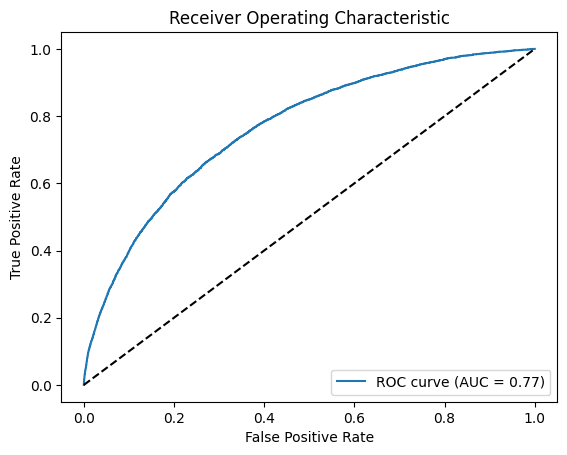

In [15]:
model_full.plot_roc_auc()

### Take a look at feature importances - what is the model using to make predictions?

`ext_source_1|2|3` are the top three features these normalised datapoints supplied in the dataset frm unknown external sources

`age`, `yrs_employed` and `perc_adult_life_employed` are all high-importance features

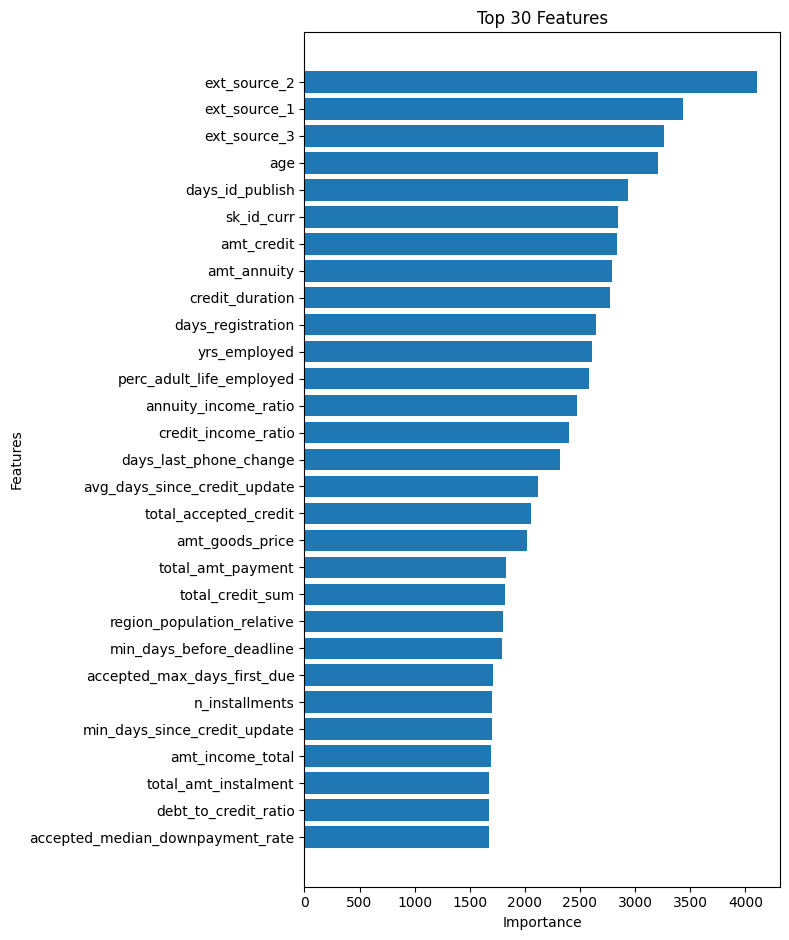

In [16]:
model_full.plot_feature_importance(n_features= 30)

## Perform bayesian optimisation of hyperparams

Set up an `objective_function()` to optimisie our model using `BayesianOptimisation()`. Limit model training to `num_boost_round=175` so increased speed, allowing more iterations of bayesian search. We can then retrain a model with the best hyperparamters for more boosting rounds.  

In [ ]:

def objective_function(learning_rate,max_depth, 
                       scale_pos_weight, subsample,
                       colsample_bytree, num_features):

  xgb_params = {
    'max_depth': int(max_depth),
    'learning_rate': learning_rate,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'subsample':subsample,
    'colsample_bytree':colsample_bytree,
    'objective': 'binary:logistic',
    'eval_metric':'auc'
}

  model = Model(dataset_class=data)
  model.select_features(int(num_features))
  model.train_model(xgb_params,
                          num_boost_round=175,
                          early_stopping_rounds=10,
                          print_training_evaluation=False)

  # Make predictions and calculate evaluation metric (e.g., ROC-AUC)
  metric = model.roc_auc()
  
  # Return the negative metric value as BayesianOptimization minimizes
  return -metric
        
        # Define the hyperparameter search space for Bayesian optimization
# Define the parameter ranges for Bayesian optimization
pbounds = {
    'learning_rate': (0.005, 0.025),
    'max_depth': (5, 15),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.3, 1),
    'scale_pos_weight': (3,20), 
    'num_features': (50,data.X_train.shape[1])
}


# Perform Bayesian optimization
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=10, n_iter=10)

|   iter    |  target   | colsam... | learni... | max_depth | num_fe... | scale_... | subsample |
-------------------------------------------------------------------------------------------------
Model training completed
| 1         | -0.7571   | 0.5622    | 0.02401   | 12.32     | 200.9     | 5.652     | 0.4092    |
Model training completed
| 2         | -0.7636   | 0.3407    | 0.02232   | 11.01     | 228.4     | 3.35      | 0.9789    |
Model training completed
| 3         | -0.7494   | 0.8827    | 0.009247  | 6.818     | 96.22     | 8.172     | 0.6673    |
Model training completed
| 4         | -0.7532   | 0.6024    | 0.01082   | 11.12     | 85.15     | 7.966     | 0.5565    |
Model training completed
| 5         | -0.7621   | 0.6192    | 0.0207    | 6.997     | 179.6     | 13.07     | 0.3325    |
Model training completed
| 6         | -0.746    | 0.7253    | 0.00841   | 5.651     | 289.1     | 19.42     | 0.8659    |
Model training completed
| 7         | -0.761    | 0.5132    | 0.0

In [ ]:
print('done')

## Train a model using best 170 features - `model_top170`

It is likely that many of our features contain redudant information, others will contain very little information about our target feature (loan defaulting). Therefore, we'll aim to drop features that aren't required. Decreasing noise in this manner may increase model performace, or at least simplify the model.

In [47]:
model_top170 = Model(dataset_class=data)
model_top170.select_features(num_features=170)
model_top170.train_model(xgb_params,num_boost_round =500, early_stopping_rounds = 50)

Model training completed


In [49]:
model_top170.evaluate_model()

Optimal Threshold: 0.650
F1 Score: 0.314
Accuracy: 0.853
Precision: 0.251
Recall (Sensitivity): 0.418
Specificity (True Negative Rate): 0.891
ROC AUC Score: 0.764
Balanced Accuracy: 0.654


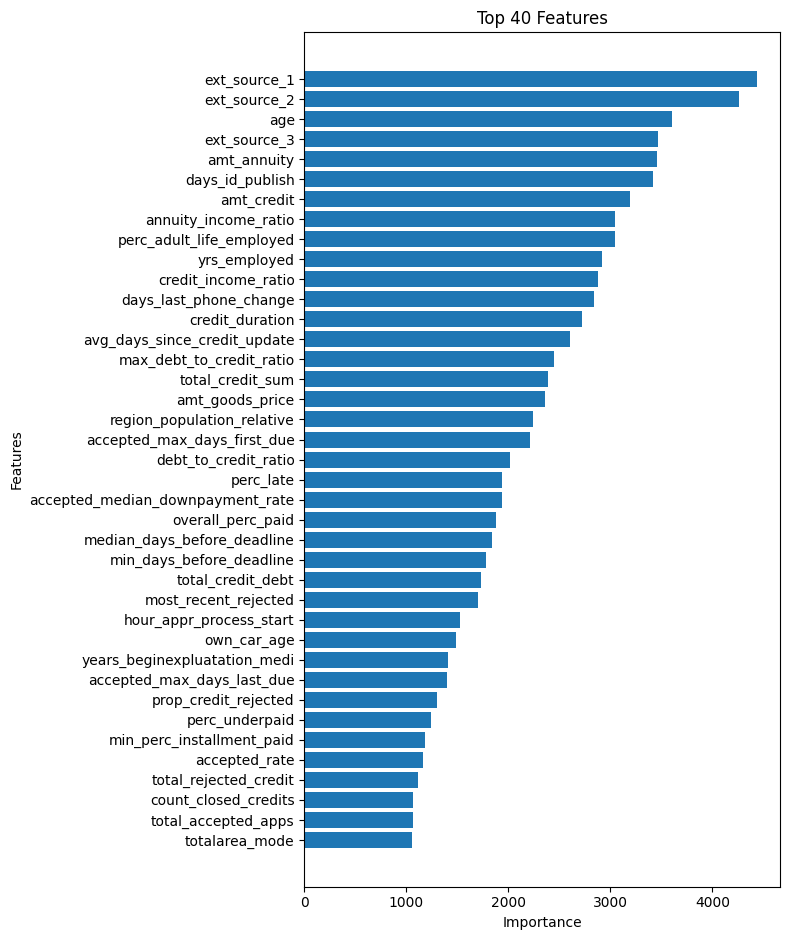

In [53]:
model_top170.plot_feature_importance(n_features=40)

## Train a model using just the 75 best features

How well can the model perform using just the top 75 `(25%)` of features.  

In [40]:
model_top75 = Model(dataset_class=data)
model_top75.select_features(num_features=75)
print(f"data has {data.X_train.shape[1]} features, model contains {model_top75.X_train.shape[1]} features")

data has 302 features, model contains 75 features


In [41]:
model_top75.selected_features

Index(['flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_credit',
       'amt_annuity', 'own_car_age', 'flag_mobil', 'flag_emp_phone',
       'flag_cont_mobile', 'flag_phone', 'ext_source_1', 'ext_source_2',
       'ext_source_3', 'elevators_avg', 'elevators_mode', 'elevators_medi',
       'obs_30_cnt_social_circle', 'def_30_cnt_social_circle',
       'obs_60_cnt_social_circle', 'def_60_cnt_social_circle',
       'flag_document_3', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'is_childless', 'count_loan_types', 'n_months_balances', 'avg_balance',
       'max_balance', 'max_weighted_balance', 'sd_balance', 'max_credit_limit',
       'total_drawings_sum', 'max_mth_drawings',
       'total_point_of_sale_drawings', 'toatl_inst_min_regularity',
       'total_payments_sum', 'total_payments_max', 'total_receivable_sum',
       'total_weighted_receivable_sum', 'avg_receivable_sum',
       'avg_weighted_receivable_sum', 'count_dpd_d

In [42]:
##train the feature selected model with same param dictionary 
model_top75.train_model(xgb_params)

Model training completed


### evaluate the performance of `model_top75`

Performance is very slighly reduced compared to all features ROC-AUC is 0.749 (0.77 in full model), and F1 score is 0.299 (0.319 in full model). This shows that we can retain almost full performance from 25% of the features. 

In [43]:
model_top75.evaluate_model()

Optimal Threshold: 0.600
F1 Score: 0.299
Accuracy: 0.826
Precision: 0.221
Recall (Sensitivity): 0.462
Specificity (True Negative Rate): 0.857
ROC AUC Score: 0.749
Balanced Accuracy: 0.659


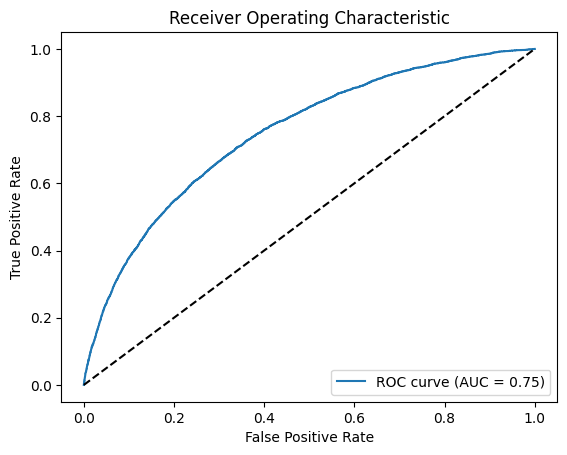

In [44]:
model_top75.plot_roc_auc()

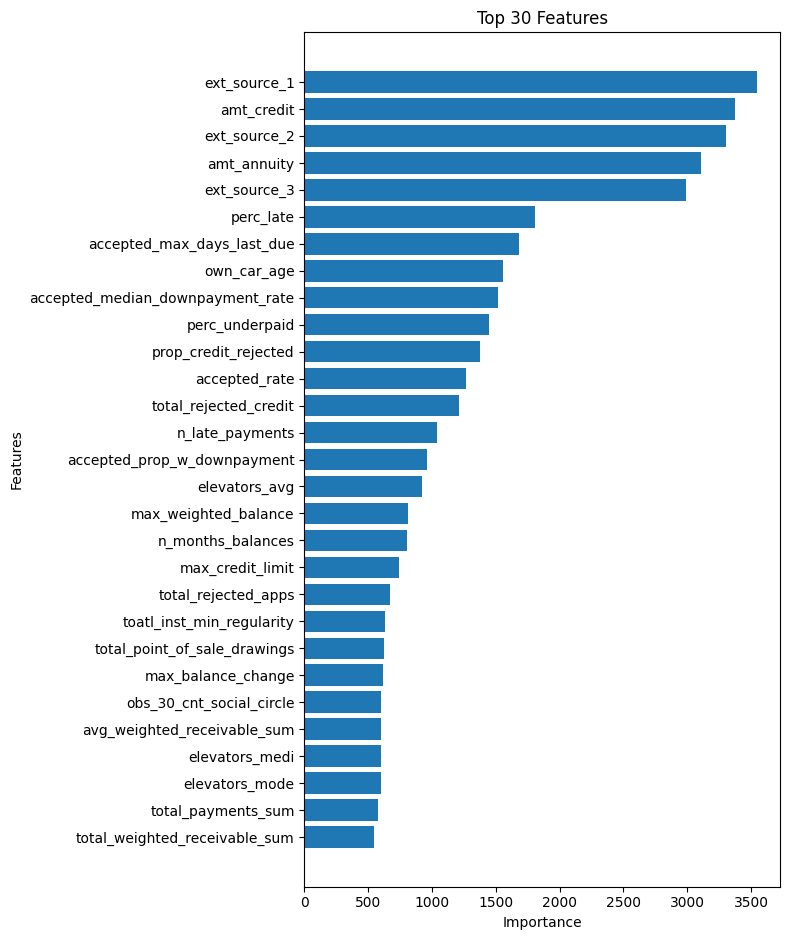

In [46]:
model_top75.plot_feature_importance(n_features=30)

In [138]:
feature_importances = model_top75.model.get_score(importance_type='weight')
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[0:33]
# Extract feature names and importance scores
features = [x[0] for x in sorted_feature_importances if not x[0].startswith('ext_source')]

features

['amt_credit',
 'amt_annuity',
 'perc_late',
 'accepted_max_days_last_due',
 'own_car_age',
 'accepted_median_downpayment_rate',
 'perc_underpaid',
 'prop_credit_rejected',
 'accepted_rate',
 'total_rejected_credit',
 'n_late_payments',
 'accepted_prop_w_downpayment',
 'elevators_avg',
 'max_weighted_balance',
 'n_months_balances',
 'max_credit_limit',
 'total_rejected_apps',
 'toatl_inst_min_regularity',
 'total_point_of_sale_drawings',
 'max_balance_change',
 'obs_30_cnt_social_circle',
 'avg_weighted_receivable_sum',
 'elevators_medi',
 'elevators_mode',
 'total_payments_sum',
 'total_weighted_receivable_sum',
 'count_loan_types',
 'max_mth_drawings',
 'avg_balance',
 'total_payments_max']

In [139]:
##drop "ext_source_columns"

data.X_train = data.X_train[features]
data.X_eval = data.X_eval[features]
data.X_test = data.X_test[features]
xgb_params2 = {
    'max_depth': 10,
    'learning_rate': 0.01,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': 15,
    'subsample':0.7,
    'colsample_bytree':1
}

model_simple = Model(dataset_class=data)
model_simple.train_model(xgb_params2,num_boost_round =250, early_stopping_rounds = 50)
model_simple.evaluate_model()

Model training completed
Optimal Threshold: 0.600
F1 Score: 0.219
Accuracy: 0.810
Precision: 0.163
Recall (Sensitivity): 0.331
Specificity (True Negative Rate): 0.852
ROC AUC Score: 0.653
Balanced Accuracy: 0.591


0.6525447869717524

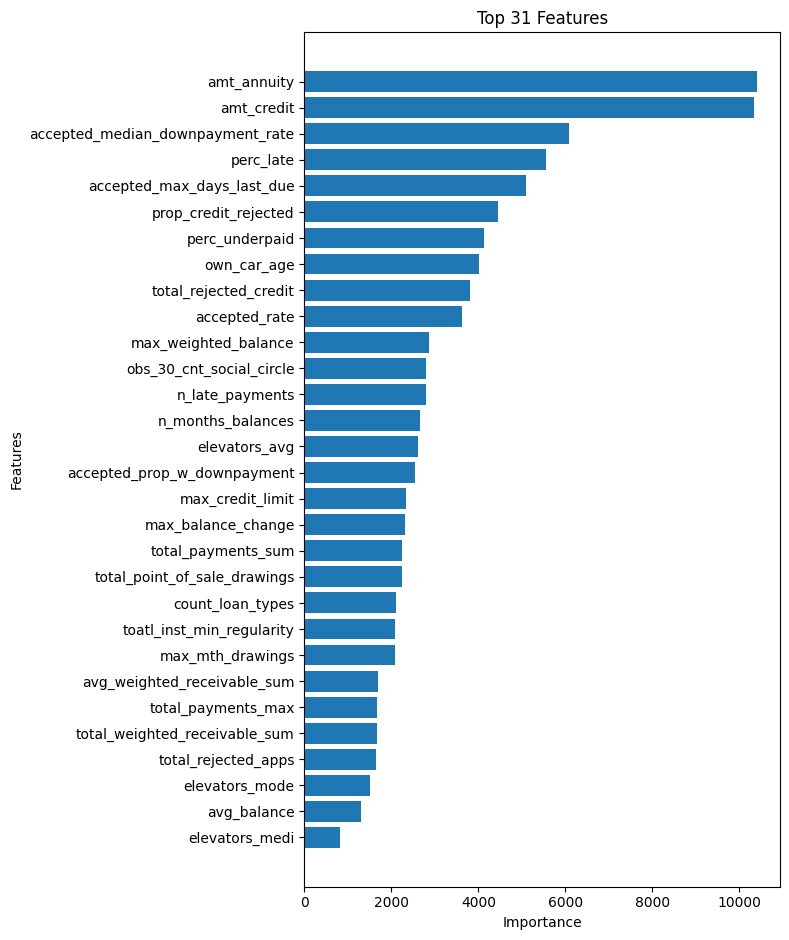

In [141]:
model_simple.plot_feature_importance(n_features = 31)

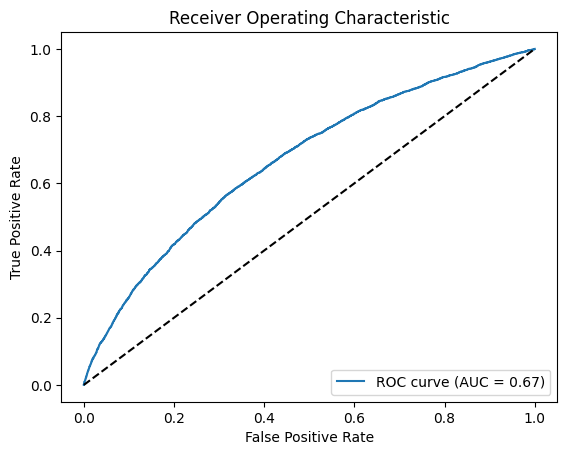

In [132]:
model_top50.plot_roc_auc()

In [133]:
model_top50.selected_features

Index(['flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_annuity',
       'own_car_age', 'flag_mobil', 'flag_emp_phone', 'flag_cont_mobile',
       'elevators_avg', 'elevators_mode', 'elevators_medi',
       'def_30_cnt_social_circle', 'def_60_cnt_social_circle',
       'flag_document_3', 'amt_req_credit_bureau_mon', 'is_childless',
       'count_loan_types', 'avg_balance', 'max_weighted_balance', 'sd_balance',
       'total_drawings_sum', 'max_mth_drawings', 'toatl_inst_min_regularity',
       'total_payments_sum', 'total_payments_max', 'total_receivable_sum',
       'total_weighted_receivable_sum', 'avg_receivable_sum',
       'min_balance_change', 'max_balance_change', 'perc_late',
       'perc_underpaid', 'prop_credit_rejected', 'code_gender_F',
       'code_gender_M', 'name_type_suite_Unaccompanied',
       'name_income_type_Working', 'name_education_type_Higher education',
       'name_education_type_Secondary / secondary special',
       'name_family_status_Married', 'name

## Make predictions from test dataset

In [110]:
##import test dataset 
test = pd.read_csv('all_TEST_data_merged.csv')

test_data = Dataset(test, target = None, is_test=True,scaler = data.scaler)
test_data.preprocess(impute_dict=impute_dict,
                     final_X_cols=model_full.X_train.columns,
                     imputation_kernel_iterations=2,
                     imputation_kernel_ntrees=50)

test_data.X.shape

Performing basic imputations based on 114 features supplied impute_dict
Index(['sk_id_curr', 'cnt_children', 'amt_income_total', 'amt_credit',
       'amt_annuity', 'amt_goods_price', 'region_population_relative',
       'days_registration', 'days_id_publish', 'own_car_age',
       ...
       'most_recent_accepted', 'accepted_max_days_last_due',
       'accepted_max_days_first_due', 'total_rejected_apps',
       'total_rejected_credit', 'rejected_median_downpayment_rate',
       'rejected_prop_w_downpayment', 'most_recent_rejected', 'accepted_rate',
       'prop_credit_rejected'],
      dtype='object', length=182)
8
Performing decision-tree based imputations of 8 remaining features with missing data
Scaling numeric data
One-hot-encoding categorical vars
splicing dataset to include only final_X_cols columns


(48744, 280)

In [115]:
test_y_pred = model_full.predict_prob(new_dataset=test_data)
np.sum(test_y_pred>0.65)/len(test_y_pred)

0.12506154603643527


## Make predictions based on new test data



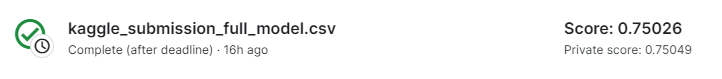

In [117]:
test['target']=test_y_pred
test['sk_id_curr'] = test['sk_id_curr'].astype('int')
kaggle_submission = test[['sk_id_curr','target']]
kaggle_submission.to_csv('kaggle_submission_full_model.csv', index=False)
kaggle_submission.head(10)

,sk_id_curr,target
0,100001,0.522069
1,100005,0.691440
2,100013,0.282805
3,100028,0.341364
4,100038,0.683656
5,100042,0.231819
6,100057,0.200391
7,100065,0.324275
8,100066,0.191047
9,100067,0.370397


In [120]:
test_df_170_features = test_data.X[model_top170.selected_features]
test_y_pred_model170 = model_top170.predict_prob(new_dataset=test_df_170_features)
test['target']=test_y_pred_model170
kaggle_submission2 = test[['sk_id_curr','target']]
kaggle_submission2.to_csv('kaggle_submission_170_feature_model.csv', index=False)
kaggle_submission2.head(10)

,sk_id_curr,target
0,100001,0.475194
1,100005,0.671770
2,100013,0.236844
3,100028,0.324500
4,100038,0.686085
5,100042,0.185977
6,100057,0.204456
7,100065,0.301881
8,100066,0.178091
9,100067,0.401785


In [96]:
kaggle_submission

,sk_id_curr,target
0,100001,0.475194
1,100005,0.671770
2,100013,0.236844
3,100028,0.324500
4,100038,0.686085
...,...,...
48739,456221,0.263429
48740,456222,0.557338
48741,456223,0.282595
48742,456224,0.333059
